In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Load and preprocess images
def load_and_process_img(image_path):
    max_dim = 400
    img = Image.open(image_path)
    long = max(img.size)
    scale = max_dim / long
    img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)))
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img) #pretrained model for feature extraction
    return img

In [3]:
# Deprocess the image to display
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [ ]:
# Load VGG19 model and extract style and content layers
def get_model():
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_layers = ['block5_conv2']
    output_layers = style_layers + content_layers
    outputs = [vgg.get_layer(name).output for name in output_layers]
    model = tf.keras.Model([vgg.input], outputs)
    return model, style_layers, content_layers

In [ ]:


# Extract content and style features from the images
def get_feature_representations(model, content_img, style_img):
    content_outputs = model(content_img)
    style_outputs = model(style_img)
    style_features = [style_outputs[i] for i in range(len(STYLE_LAYERS))]
    content_features = [content_outputs[len(STYLE_LAYERS):][0]]
    return content_features, style_features

In [ ]:

# Calculate the content loss
def content_loss(content, target):
    return tf.reduce_mean(tf.square(content - target))


In [ ]:
# Gram matrix for style loss
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    num_locations = tf.cast(tf.shape(input_tensor)[1] * tf.shape(input_tensor)[2], tf.float32)
    return result / num_locations

In [ ]:
# Calculate style loss
def style_loss(style, gram_target):
    gram_style = gram_matrix(style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [ ]:
# Compute the total loss
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)

    style_output_features = model_outputs[:len(STYLE_LAYERS)]
    content_output_features = model_outputs[len(STYLE_LAYERS):]

    # Compute content loss
    content_score = content_loss(content_output_features[0], content_features[0])

    # Compute style loss
    style_score = 0
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += style_loss(comb_style, target_style)

    style_score *= style_weight
    content_score *= content_weight

    total_loss = style_score + content_score
    return total_loss

In [ ]:


# Compute gradients
@tf.function()
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [ ]:
#Run the style transfer process
def run_style_transfer(content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2):
    model, style_layers, content_layers = get_model()

    global STYLE_LAYERS
    STYLE_LAYERS = style_layers

    content_img = load_and_process_img(content_path)
    style_img = load_and_process_img(style_path)

    content_features, style_features = get_feature_representations(model, content_img, style_img)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    init_image = tf.Variable(content_img, dtype=tf.float32)
    opt = tf.optimizers.Adam(learning_rate=5.0)

    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        opt.apply_gradients([(grads, init_image)])

        if i % 100 == 0:
            print(f"Iteration: {i}, Loss: {all_loss}")
            output_img = deprocess_img(init_image.numpy())
            plt.imshow(output_img)
            plt.show()

    return deprocess_img(init_image.numpy())

In [ ]:
# Specify paths to the content and style images
content_path = 'content.jpg'
style_path = 'style.jpg'

Iteration: 0, Loss: 1764739072.0


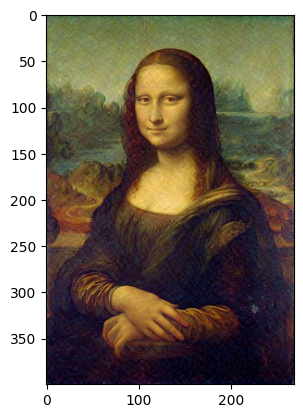

Iteration: 100, Loss: 12729470.0


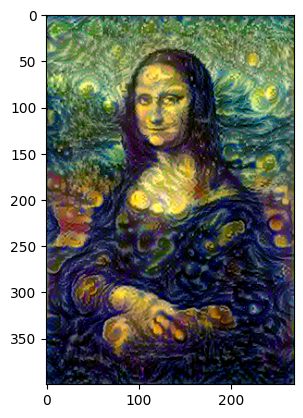

Iteration: 200, Loss: 7903820.0


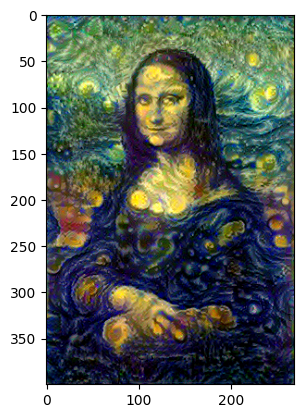

Iteration: 300, Loss: 6209609.0


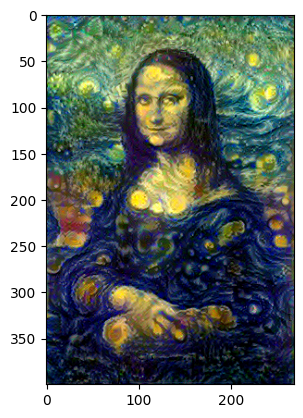

Iteration: 400, Loss: 5308061.5


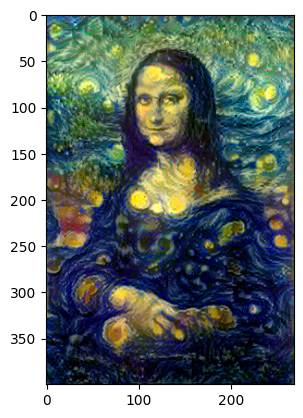

Iteration: 500, Loss: 5063543.5


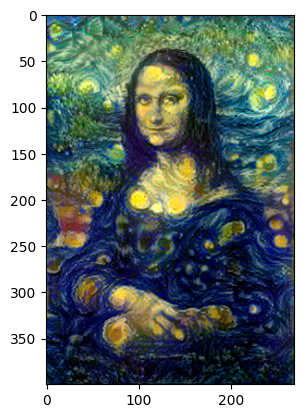

Iteration: 600, Loss: 5253216.0


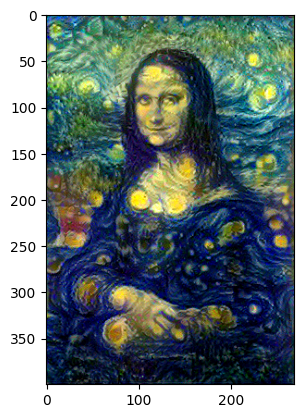

Iteration: 700, Loss: 4940328.5


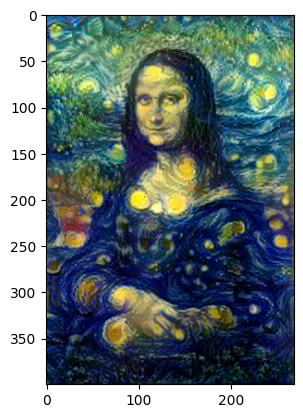

Iteration: 800, Loss: 4046211.5


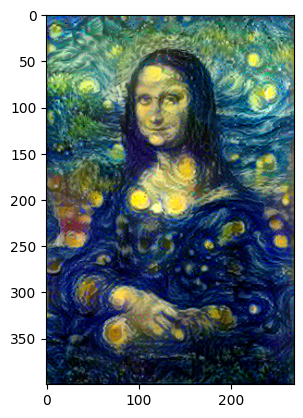

Iteration: 900, Loss: 3670695.0


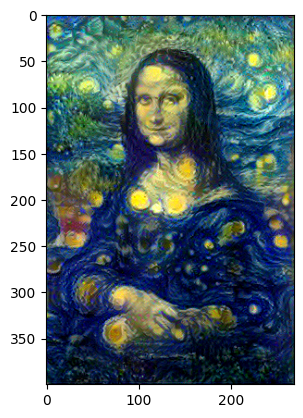

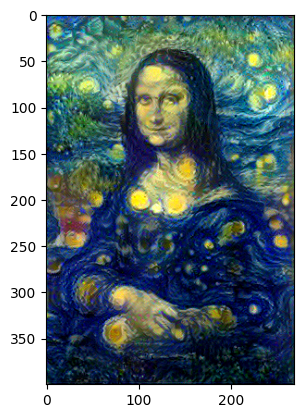

In [2]:

# Run style transfer
output_image = run_style_transfer(content_path, style_path, num_iterations=1000)
plt.imshow(output_image)
plt.show()
